In -> Convolution -> Activation -> Pooling -> Flatten -> DFF-NN -> Out
Forward pass should use kernels and produce a feature_map for each kernel

seperate kernel for each feature: edges, textures, shapes, etc
Image is in greyscale... no need for color channels, just pixel intensity

In [3]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import pandas as pd

from cv2 import imread
from math import radians
from re import findall
from scipy.signal import correlate2d
from ipynb.fs.full.TestPreProcess import Data

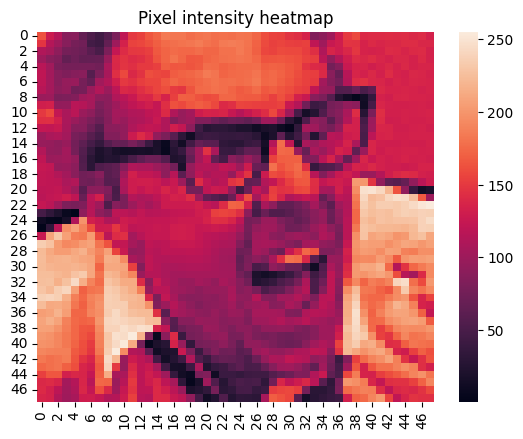

In [4]:
image = imread("../Data/train/angry/Training_3908.jpg")

height, width, channels = image.shape
pixels = np.array([[int(image[h][w][0]) for w in range(width)] for h in range(height)], np.float64)

plt.title("Pixel intensity heatmap")
sbn.heatmap(pixels)
plt.show()

In [5]:
class Convolution:
    """
    Required parameters:
        input_shape - np.array.shape [used to create shape for weights]
        kernel_shape - (number of kernels, height and width of kernel) [used for feature extraction]
    Optional parameters:
        activation_function - string relu | sigmoid | tanh [determines activation behavior]
        kernel_weights - np.array [Used for pre-trained network]
        bias_weights - np.array [Used for pre-trained network]
    Methods:
        select_features(2d-array) => feature map, one per kernel
        train_selector(2d-array) => adjust bias and kernel weights
    """
    def __init__(self, input_shape, kernel_shape, activation_function="relu", learning_rate=0.02, kernel_weights=np.array([]), bias_weights=np.array([])):
        self.input_height, self.input_width, self.number_of_channels = input_shape
        self.number_of_kernels, self.kernel_height, self.kernel_width = kernel_shape
        self.activation_function = activation_function
        self.learning_rate = learning_rate

        self.output_shape = (self.number_of_kernels, self.input_height - self.kernel_height + 1, self.input_width - self.kernel_width + 1)
        self.kernels = kernel_weights if kernel_weights.any() else np.random.randn(*kernel_shape)
        self.biases = bias_weights if bias_weights.any() else np.random.randn(*self.output_shape)

        self.cache = None
        self.output = None

    def select_features(self, data):
        self.cache = data
        output = np.zeros(self.output_shape)

        for i in range(self.number_of_kernels):
            # handle kernel stride via 2d correlation
            output[i] = correlate2d(data, self.kernels[i], mode="valid")

        if self.activation_function == "relu":
            output = np.maximum(output, 0)
        if self.activation_function == "sigmoid":
            output = 1 / (1 + np.exp(-output))
        if self.activation_function == "tanh":
            output = np.tanh(radians(output))
        
        self.output = output
        return self.output
    
    def train_selector(self, data):
        output = np.zeros_like(self.cache)
        kernel_loss = np.zeros_like(self.kernels)

        for i in range(self.number_of_kernels):
            kernel_loss[i] = correlate2d(self.cache, data[i], mode="valid")
            output += correlate2d(data[i], self.kernels[i], mode="full")

        self.kernels -= self.learning_rate * kernel_loss
        self.biases -= self.learning_rate * data

        return output

    def __repr__(self):
        pass

In [6]:
class Pooling:
    """
    Required parameters:
        pooling_window_shape - np.array.shape [Sets pooling window dimensions]
    Optional parameters:
        pooling_function - string max | ave | min [determines pooling behavior]
    Methods:
        pool(feature_map_array) => pooled array
        unpool(pooled array) => expanded 2d array
    """
    def __init__(self, pooling_window_shape, pooling_function="max"):
        self.pooling_window_height, self.pooling_window_width = pooling_window_shape
        self.pooling_function = pooling_function

        self.cache = None
        self.output = None

    def pool(self, data):
        self.cache = data
        number_of_features, input_height, input_width = data.shape
        output_height = input_height // self.pooling_window_height
        output_width = input_width // self.pooling_window_width

        output = np.zeros((number_of_features, output_height, output_width))

        for feature in range(number_of_features):
            for y in range(output_height):
                for x in range(output_width):

                    window = data[
                        feature, 
                        y * self.pooling_window_height : (y + 1) * self.pooling_window_height,
                        x * self.pooling_window_width : (x + 1) * self.pooling_window_width
                        ]
                    
                    if self.pooling_function == "max":
                        output[feature, y, x] = np.max(window)
                    if self.pooling_function == "ave":
                        output[feature, y, x] = np.mean(window)
                    if self.pooling_function == "min":
                        output[feature, y, x] = np.min(window)

        self.output = output
        return self.output
    
    def unpool(self, data):
        number_of_features, input_height, input_width = data.shape
        output = np.zeros_like(self.cache)

        for feature in range(number_of_features):
            for y in range(input_height):
                for x in range(input_width):

                    window = self.cache[
                        feature, 
                        y * self.pooling_window_height : (y + 1) * self.pooling_window_height,
                        x * self.pooling_window_width : (x + 1) * self.pooling_window_width
                        ]

                    if self.pooling_function == "max":
                        mask = window == np.max(window)
                    if self.pooling_function == "ave":
                        mask = window == np.mean(window)
                    if self.pooling_function == "min":
                        mask = window == np.min(window)

                    output[
                        feature, 
                        y * self.pooling_window_height : (y + 1) * self.pooling_window_height,
                        x * self.pooling_window_width : (x + 1) * self.pooling_window_width
                        ] = data[feature, y, x] * mask

        return output
    
    def __repr__(self):
        pass

In [7]:
class Flatten:
    """
    Methods:
        flatten(pooled array) => flattened array
        unflatten(flattened array) => pooled array
    """
    def __init__(self):
        self.shape = None

    def flatten(self, data):
        self.shape = data.shape
        return data.flatten().reshape(1, -1).T
    
    def unflatten(self, data):
        return data.reshape(self.shape)

    def __repr__(self):
        pass

In [8]:
class FeedForward:
    """
    Required parameters:
        input_shape - np.array.shape [used to create shape for weights]
        kernel_shape - (number of kernels, height and width of kernel) [used for feature extraction]
    Optional parameters:
        dropout - (TODO: learn about dropout)
        weights - np.array [Used for pre-trained network]
        biases - np.array [Used for pre-trained network]
        learning_rate - float [used to control proportion of difference fed back for learning]
        activation_function - string softmax | (TODO: add other activation functions) [determine the output]
    Methods:
        forward_pass(flattened array) => array probabilities for each category
        backpropegate(explanatroy variable, response wariable) => updata weights and biases to accomodate learnign
    """
    def __init__(self, input_size, output_size, dropout=None, weights=np.array([]), biases=np.array([]), learning_rate=0.02, activation_function="softmax"):
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.activation_function = activation_function

        self.weights = weights if weights.any() else np.random.randn(output_size, input_size)
        self.biases = biases if biases.any() else np.random.rand(output_size, 1)
        
        self.cache = None
        self.output = None

    def forward_pass(self, data):
        # TODO: learn about and implement dropout
        self.cache = data

        dot_product= np.dot(self.weights, data) + self.biases

        if self.activation_function == "softmax":
            exp_logits = np.exp(dot_product - np.max(dot_product))
            output = exp_logits / exp_logits.sum()
        # TODO: implement other activation functions along with their corresponding derivatives

        self.output = output
        return self.output
    
    def softmax_derivative(self, data):
        return np.diagflat(data) - np.dot(data, data.T)
    
    def cross_entropy_loss_gradient(self, expected, prediction):
        return -expected / (prediction + 1e-7) / expected.shape[0]

    def backpropegate(self, data, expected):
        gradient = self.cross_entropy_loss_gradient(expected, data)

        biases_gradient = np.dot(self.softmax_derivative(self.output), gradient)
        weight_gradient = np.dot(biases_gradient, self.cache.flatten().reshape(1, -1))

        self.weights -= self.learning_rate * weight_gradient
        self.biases -= self.learning_rate * biases_gradient

        return np.dot(self.weights.T, biases_gradient).reshape(self.cache.shape)

    def __repr__(self):
        pass

In [13]:
"""Combined testing full forward pass with backpropegation"""
# Convolution
kernel_hieght, kernel_width = (3, 3)
kernel_count = 3

convolution_layer = Convolution(image.shape, (kernel_count, kernel_hieght, kernel_width))
conv_forward = convolution_layer.select_features(pixels)

# Pooling
pooling_window_height = 3
pooling_window_width = 3

pooling_layer = Pooling((pooling_window_height, pooling_window_width), pooling_function="max")
pool_forward = pooling_layer.pool(conv_forward)

# Flatten
flatten_layer = Flatten()
flat_forward = flatten_layer.flatten(pool_forward)

# Feed Forward
feed_layer = FeedForward(flat_forward.shape[0], 7)
feed_forward = feed_layer.forward_pass(flat_forward)

# Back propegate
ANGRY = np.array([[1.0],[0.],[0.],[0.],[0.],[0.],[0.]])

feed_back = feed_layer.backpropegate(feed_forward, ANGRY)
flat_back = flatten_layer.unflatten(feed_back)
pool_back = pooling_layer.unpool(flat_back)
conv_back = convolution_layer.train_selector(pool_back)

# Check returned data
print(conv_back)


[[ 2.76910854e-28 -1.29269462e-27  3.01099713e-28 ... -1.55366573e-27
  -1.15841014e-27  0.00000000e+00]
 [ 4.03536049e-27  7.47505486e-28  2.58863346e-27 ...  1.15794740e-27
  -1.31608822e-27  0.00000000e+00]
 [ 2.80106944e-27  6.75012792e-28  3.89016679e-27 ... -2.96388659e-27
  -5.29083303e-27  0.00000000e+00]
 ...
 [-2.75025060e-27  2.76263215e-27  4.05033249e-27 ...  2.66272301e-27
  -6.51938735e-27  0.00000000e+00]
 [ 1.72243879e-27  4.62207463e-27  9.13362201e-27 ... -1.62165744e-27
  -3.93876575e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [14]:
"""Prediction mechanism"""
encoded_output = np.zeros_like(feed_forward)
encoded_output[np.argmax(feed_forward)] = 1
predicted_index = np.argmax(encoded_output.flatten())

print("raw out:", feed_forward.flatten())
print("encoded output:", encoded_output.flatten())
print("forward_pass prediction:", predicted_index)

raw out: [1.00000000e+00 5.20066945e-50 8.05005497e-27 2.22150183e-72
 3.81318211e-65 1.71300762e-67 8.94965034e-45]
encoded output: [1. 0. 0. 0. 0. 0. 0.]
forward_pass prediction: 0


In [15]:
"""Load in all data"""
data = Data(img_size=48)

In [21]:
class Network:
    """
    Required parameters:
        input_shape - np.array.shape [set uniform image shape throughout network]
        layer_list - [layer, layer, ...] [used to set network layer architecture]
    Methods:
        train(explanatory_array, response_array, cycle_count) => trains network
        validate(explanatory_array, response_array) => TODO: validation loss 
        predict(explanatory_array) => predictions_dataframe
        save_network([path_name]) => path_name.csv saved to disk
        static load_network([path_name]) => load path_name.csv from disk
    """
    def __init__(self, image_shape, layer_list):
        self.network = []
        self.feed_input_size = None
        for layer in layer_list:
            if "conv" in layer.keys():
                convolution_layer = Convolution(image_shape, **layer["conv"])
                convolution_layer.forward = convolution_layer.select_features
                convolution_layer.back = convolution_layer.train_selector
                self.network.append(convolution_layer)

                number_of_kernels, kernel_height, kernel_width = layer["conv"]["kernel_shape"]
                self.feed_input_size = (number_of_kernels, image_shape[0] - kernel_height + 1, image_shape[1] - kernel_width + 1)
            if "pool" in layer.keys():
                pooling_layer = Pooling(**layer["pool"])
                pooling_layer.forward = pooling_layer.pool
                pooling_layer.back = pooling_layer.unpool
                self.network.append(pooling_layer)

                # BUG: this will fail if preceeded by feed of flat layer..
                number_of_features, input_height, input_width = self.feed_input_size 
                pooling_window_height, pooling_window_width = layer["pool"]["pooling_window_shape"]
                output_height = input_height // pooling_window_height
                output_width = input_width // pooling_window_width
                self.feed_input_size = (number_of_features, output_height, output_width)
            if "flat" in layer.keys():
                flatten_layer = Flatten()
                flatten_layer.forward = flatten_layer.flatten
                flatten_layer.back = flatten_layer.unflatten
                self.network.append(flatten_layer)

                self.feed_input_size = np.prod(self.feed_input_size)
            if "feed" in layer.keys():
                feed_layer = FeedForward(self.feed_input_size, **layer["feed"])
                feed_layer.forward = feed_layer.forward_pass
                feed_layer.back = feed_layer.backpropegate
                self.network.append(feed_layer)

                self.feed_input_size = layer["feed"]["output_size"]

    def _cross_entropy_loss(self, forward_pass, desired):
        epsilon = 1e-7
        forward_pass = np.clip(forward_pass, epsilon, 1 - epsilon)

        return -np.sum(desired * np.log(forward_pass)) / 7

    def _run_network(self, data, ground_truth=np.array([])):
        predictions = pd.DataFrame(columns=["prediction"])
        loss = 0

        for i in range(len(data)):
            image = data[i]
            forward_pass = image.reshape([image.shape[0], image.shape[1]])
            for layer in self.network:
                forward_pass = layer.forward(forward_pass)
            
            if ground_truth.any():
                truth = ground_truth[i].reshape([7, 1])
                loss += self._cross_entropy_loss(forward_pass.flatten(), truth)
                backward_pass = forward_pass
                for layer in reversed(self.network):
                    if type(layer) == FeedForward:
                        backward_pass = layer.back(backward_pass, truth)
                    else:
                        backward_pass = layer.back(backward_pass)
            else:
                encoded_output = np.zeros_like(forward_pass)
                encoded_output[np.argmax(forward_pass)] = 1
                predictions.loc[len(predictions)] = np.argmax(encoded_output.flatten())
        
        return loss if ground_truth.any() else predictions

    def train(self, training_data, truth, cycles):
        for i in range(cycles):
            self._run_network(training_data, truth)

    def validate(self, validation_data, truth):
        return self._run_network(validation_data, truth)

    def predict(self, testing_data):
        return self._run_network(testing_data)

    def save_network(self, path_name=""):
        path_name = f"_{path_name}" if path_name else ""
        conv_out = pd.DataFrame(columns=["conv_kernel", "conv_bias"])
        feed_out = pd.DataFrame(columns=["feed_weights", "feed_bias"])
        for layer in self.network:
            if type(layer) == Convolution:
                conv_out["conv_kernel"] = layer.kernels.tolist()
                conv_out["conv_bias"] = layer.biases.tolist()
            if type(layer) == FeedForward:
                feed_out["feed_weights"] = layer.weights.tolist()
                feed_out["feed_bias"] = layer.biases.tolist()

        conv_out.to_csv(f"../Saved/conv{path_name}.csv", index=False)
        feed_out.to_csv(f"../Saved/feed{path_name}.csv", index=False)

    @staticmethod
    def load_network(path_name=""):
        path_name = f"_{path_name}" if path_name else ""

        def load_conv(column):
            outer = []
            for string in column.values:
                middle = []
                for group in findall(r"\[(.*?)\]", string):
                    new = group.replace("[", "")
                    new.replace("]", "")
                    middle.append([float(n) for n in new.split(",")])
                outer.append(middle)
            return np.array(outer)

        def load_feed(column):
            outer = []
            for string in column.values:
                for group in findall(r"\[(.*?)\]", string):
                    new = group.replace("[", "")
                    new.replace("]", "")
                    outer.append([float(n) for n in new.split(",")])
            return np.array(outer)

        saved_conv = pd.read_csv(f"../Saved/conv{path_name}.csv")
        conv_kernel = load_conv(saved_conv["conv_kernel"])
        conv_bias = load_conv(saved_conv["conv_bias"])

        saved_feed = pd.read_csv(f"../Saved/feed{path_name}.csv")
        feed_weights = load_feed(saved_feed["feed_weights"])
        feed_bias = load_feed(saved_feed["feed_bias"])

        return conv_kernel, conv_bias, feed_weights, feed_bias

In [ ]:
"""Start with class weights from earlier run"""
image_shape = data.X_train.shape[1:]

layers = [
    {"conv": dict(kernel_shape=(3, 3, 3), activation_function="relu", learning_rate=0.02, kernel_weights=convolution_layer.kernels, bias_weights=convolution_layer.biases)}, 
    {"pool": dict(pooling_window_shape=(3, 3), pooling_function="max")}, 
    {"flat": None},
    {"feed": dict(output_size=7, dropout=None, learning_rate=0.02, activation_function="softmax", weights=feed_layer.weights, biases=feed_layer.biases)}
    ]
cnn = Network(image_shape, layers)

cnn.train(data.X_train, data.y_train, cycles=1)

In [23]:
"""Start with saved weights"""
image_shape = data.X_train.shape[1:]
conv_kernel, conv_bias, feed_weights, feed_bias = Network.load_network("")

layers = [
    {"conv": dict(kernel_shape=(3, 3, 3), activation_function="relu", learning_rate=0.02, kernel_weights=conv_kernel, bias_weights=conv_bias)}, 
    {"pool": dict(pooling_window_shape=(3, 3), pooling_function="max")}, 
    {"flat": None},
    {"feed": dict(output_size=7, dropout=None, learning_rate=0.02, activation_function="softmax", weights=feed_weights, biases=feed_bias)}
    ]
cnn = Network(image_shape, layers)

# cnn.train(data.X_train, data.y_train, cycles=1)

In [ ]:
"""Start with random weights"""
image_shape = data.X_train.shape[1:]

layers = [
    {"conv": dict(kernel_shape=(3, 3, 3), activation_function="relu", learning_rate=0.02)}, 
    {"pool": dict(pooling_window_shape=(3, 3), pooling_function="max")}, 
    {"flat": None},
    {"feed": dict(output_size=7, dropout=None, learning_rate=0.02, activation_function="softmax")}
    ]
cnn = Network(image_shape, layers)

cnn.train(data.X_train, data.y_train, cycles=1)

In [24]:
predictions = cnn.predict(data.X_test)
predictions["truth"] = np.argmax(data.y_test, axis=1)
predictions["accurate"] = predictions["prediction"] == predictions["truth"]
print(predictions)
print("prediction accuracy:", np.sum(predictions["accurate"])/len(predictions))
# predictions.loc[predictions["accurate"] == False]

      prediction  truth  accurate
0              3      3      True
1              3      4     False
2              3      2     False
3              3      6     False
4              3      2     False
...          ...    ...       ...
7173           3      6     False
7174           3      5     False
7175           3      6     False
7176           3      4     False
7177           3      5     False

[7178 rows x 3 columns]
prediction accuracy: 0.24895514070771801


In [22]:
cnn.save_network("")

In [25]:
validation_loss = cnn.validate(data.X_val, data.y_val)
print(validation_loss)

79298.03740938696


In [26]:
"""direct comparision against hand-coded network"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Input, MaxPooling2D, Dropout

model = Sequential()
model.add(Input(shape=image_shape))
model.add(Conv2D(3, kernel_size= 3, activation='relu' ))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
 
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(data.X_train, data.y_train, epochs=5)
test_loss, test_accuracy = model.evaluate(data.X_test, data.y_test)
print(test_accuracy)

2025-03-21 20:57:30.554798: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 675)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         4,732 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,762 (18.60 KB)

 Trainable params: 4,762 (18.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2781 - loss: 1.7884
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3743 - loss: 1.6369
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3975 - loss: 1.5845
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4058 - loss: 1.5525
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4220 - loss: 1.5197
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4102 - loss: 1.5389
0.4139035940170288
